# Measuring peak coordinates for LoVoCCS clusters

One of the initial stages of our analysis of the LoVoCCS sample was to examine the MCXC (the catalog which LoVoCCS was selected from) coordinate in the context of more modern telescopes, and to adjust it to a better 'starting coordinate' if it was significantly offset from the center of the ICM emission. This also included adding new LoVoCCS sample entries if the original MCXC cluster actually has multiple subcomponents.

This notebook makes use of these 'starting coordinates', our processed XMM observations, and XGA functionality, to measure the peak coordinates of each of our galaxy clusters - this is one of the most commonly used central position definitions for X-ray emission from galaxy clusters (in another notebook we measure the ICM centroid, another popular central coordinate measure).

## Import Statements

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
from astropy.units import Quantity, UnitConversionError
from astropy.cosmology import LambdaCDM
from shutil import rmtree
import os
from matplotlib import pyplot as plt

import xga
xga.NUM_CORES = 5
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample

# This is a bit cheeky, but suppresses the warnings that XGA spits out (they are 
#  useful, but not when I'm trying to present this notebook on GitHub)
import warnings
warnings.filterwarnings('ignore')

# Set up a variable that controls how long individual XSPEC fits are allowed to run
timeout = Quantity(6, 'hr')

%matplotlib inline

## Setting up necessary directories

Here we ensure that the directories we need to store the outputs in have been created:

In [2]:
if not os.path.exists("../../outputs/figures/positions/"):
    os.makedirs("../../outputs/figures/positions/")
    
if not os.path.exists("../../outputs/coordinates"):
    os.makedirs("../../outputs/coordinates/")
    
if not os.path.exists("../../outputs/cluster_visualisations/peak_coord_meas/"):
    os.makedirs("../../outputs/cluster_visualisations/peak_coord_meas/")

## Reading in the sample

We read in the LoVoCCS sample relevant to the current work:

In [3]:
samp = pd.read_csv("../../sample_files/X-LoVoCCSI.csv")
samp['LoVoCCS_name'] = samp['LoVoCCSID'].apply(lambda x: "LoVoCCS-" + str(x))
samp

,LoVoCCSID,Name,start_ra,start_dec,MCXC_Redshift,MCXC_R500,MCXC_RA,MCXC_DEC,manual_xray_ra,manual_xray_dec,LoVoCCS_name
0,1,A2029,227.734300,5.745471,0.0766,1.3344,227.73000,5.720000,227.734300,5.745471,LoVoCCS-1
1,2,A401,44.740000,13.580000,0.0739,1.2421,44.74000,13.580000,NaN,NaN,LoVoCCS-2
2,4,A85,10.458750,-9.301944,0.0555,1.2103,10.45875,-9.301944,NaN,NaN,LoVoCCS-4
3,5,A3667,303.157313,-56.845978,0.0556,1.1990,303.13000,-56.830000,303.157313,-56.845978,LoVoCCS-5
4,7,A3827,330.480000,-59.950000,0.0980,1.1367,330.48000,-59.950000,NaN,NaN,LoVoCCS-7
...,...,...,...,...,...,...,...,...,...,...,...
61,121,A3128,52.466189,-52.580728,0.0624,0.8831,52.50000,-52.600000,52.466189,-52.580728,LoVoCCS-121
62,122,A1023,157.000000,-6.800000,0.1176,0.8553,157.00000,-6.800000,NaN,NaN,LoVoCCS-122
63,123,A3528,193.670000,-29.220000,0.0544,0.8855,193.67000,-29.220000,NaN,NaN,LoVoCCS-123
64,131,A761,137.651250,-10.581111,0.0916,0.8627,137.65125,-10.581111,NaN,NaN,LoVoCCS-131


## Defining an XGA ClusterSample

We are going to use the [XGA hierarchical clustering peak finder](https://xga.readthedocs.io/en/latest/notebooks/techniques/hierarchical_clustering_peak_finding.html), which is built into [the RateMap](https://xga.readthedocs.io/en/latest/xga.products.html#xga.products.phot.RateMap.clustering_peak) class - this is the XGA Python class that provides convenient interfaces with count-rate maps. However, we won't use the count-rate map method directly, instead we'll declare a cluster sample and use the hierarchical peak finder that way - the advantage of this approach is twofold; 

**(1)** declaring the cluster sample will assemble a mask to remove contaminating sources from each cluster's observations, which may improve the performance of the peak finder; and **(2)** the GalaxyCluster call to the peak finder is iterative, and will try to converge on the best value.

We use the 'start_ra' and 'start_dec' columns of the sample, which act as good starting positions for our analyses of these clusters (they will contain the MCXC position column values if we didn't manually adjust the position, and the manual_xray_* column values if we did).

As we define the ClusterSample with `use_peak=True` and `peak_find_method='hierarchical'`, the peaks will automatically be calculated during declaration. We have also set `clean_obs=False`, which means that **no** checks will be performed on obserations to make sure that a minimum fraction of $R_{500}$ falls on them - this shouldn't be necessary for this analysis.

In [4]:
srcs = ClusterSample(samp['start_ra'].values, samp['start_dec'].values, samp['MCXC_Redshift'].values, 
                     samp['LoVoCCS_name'].values, r500=Quantity(samp['MCXC_R500'].values, 'Mpc'), use_peak=True,
                     peak_find_method='hierarchical', clean_obs=False)

Setting up Galaxy Clusters:  50%|█████     | 1/2 [00:10<00:10, 10.72s/it]

ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division
Setting up Galaxy Clusters: 100%|██████████| 2/2 [00:29<00:00, 14.58s/it]


In [12]:
srcs.failed_reasons

{'LoVoCCS-1': 'NoMatch',
 'LoVoCCS-2': 'NoMatch',
 'LoVoCCS-4': 'NoMatch',
 'LoVoCCS-5': 'NoMatch',
 'LoVoCCS-7': 'NoMatch',
 'LoVoCCS-9': 'NoMatch',
 'LoVoCCS-10': 'NoMatch',
 'LoVoCCS-11': 'NoMatch',
 'LoVoCCS-12': 'NoMatch',
 'LoVoCCS-13': 'NoMatch',
 'LoVoCCS-14': 'NoMatch',
 'LoVoCCS-18': 'NoMatch',
 'LoVoCCS-21': 'NoMatch',
 'LoVoCCS-22': 'NoMatch',
 'LoVoCCS-24': 'NoMatch',
 'LoVoCCS-26': 'NoMatch',
 'LoVoCCS-27': 'NoMatch',
 'LoVoCCS-28': 'NoMatch',
 'LoVoCCS-29': 'NoMatch',
 'LoVoCCS-31': 'NoMatch',
 'LoVoCCS-33': 'NoMatch',
 'LoVoCCS-35': 'NoMatch',
 'LoVoCCS-39': 'NoMatch',
 'LoVoCCS-41A': 'NoMatch',
 'LoVoCCS-41B': 'NoMatch',
 'LoVoCCS-41C': 'NoMatch',
 'LoVoCCS-42': 'NoMatch',
 'LoVoCCS-45': 'NoMatch',
 'LoVoCCS-46A': 'NoMatch',
 'LoVoCCS-46B': 'NoMatch',
 'LoVoCCS-46C': 'NoMatch',
 'LoVoCCS-48A': 'NoMatch',
 'LoVoCCS-48B': 'NoMatch',
 'LoVoCCS-49': 'NoMatch',
 'LoVoCCS-51': 'NoMatch',
 'LoVoCCS-55': 'NoMatch',
 'LoVoCCS-58': 'NoMatch',
 'LoVoCCS-60A': 'NoMatch',
 'LoVoCCS

In [5]:
srcs.info()


-----------------------------------------------------
Number of Sources - 2
Redshift Information - True
Sources with ≥1 detection - 2 [100%]
-----------------------------------------------------



## Visualise the offset distribution

We can use a built in method of the ClusterSample to produce a histogram showing the measured offsets between user defined and peak coordinates; in fact we'll make two versions, the first in angular distance:

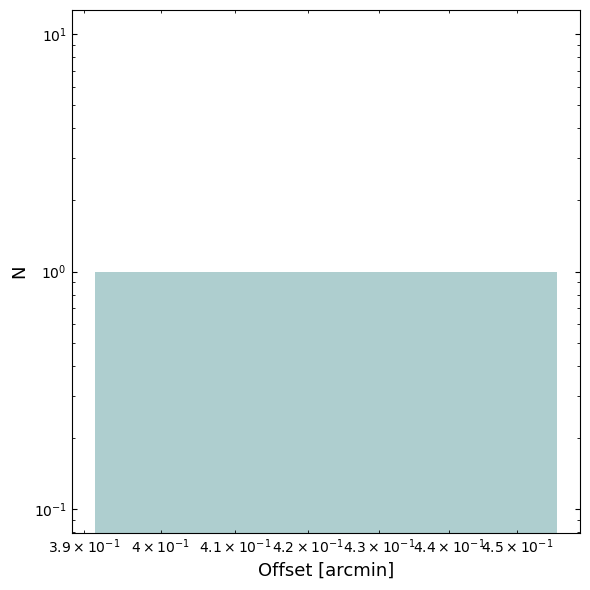

In [6]:
srcs.view_offset_dist('arcmin', 
                      save_path="../../outputs/figures/positions/startcoord_peakcoord_offsetdist_arcmin.pdf")

The second in proper distance:

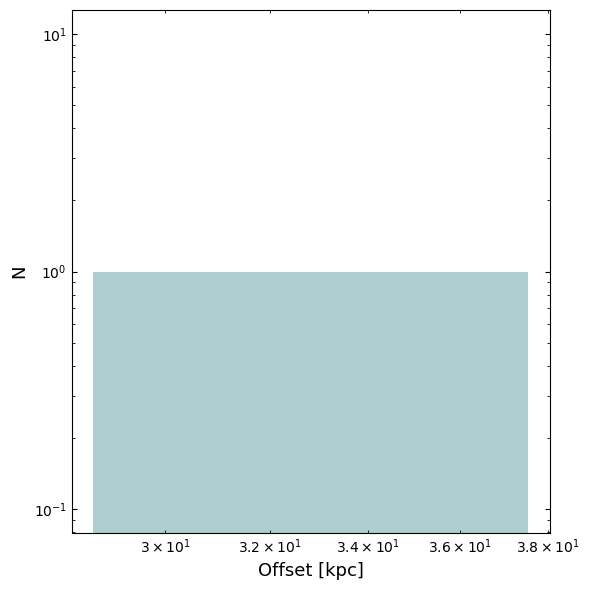

In [7]:
srcs.view_offset_dist('kpc', 
                      save_path="../../outputs/figures/positions/startcoord_peakcoord_offsetdist_kpc.pdf")

## Examine the peak coordinates

We can use the view methods of the XGA RateMap class to visualise the start coordinates and peak coordinates, as well as the 'point clusters' that the hierarchical peak finding method identified and used. This gives some visual context to the peak coordinates, and helps us to make sure that they all look sensible - we also save the visualisations to disk:

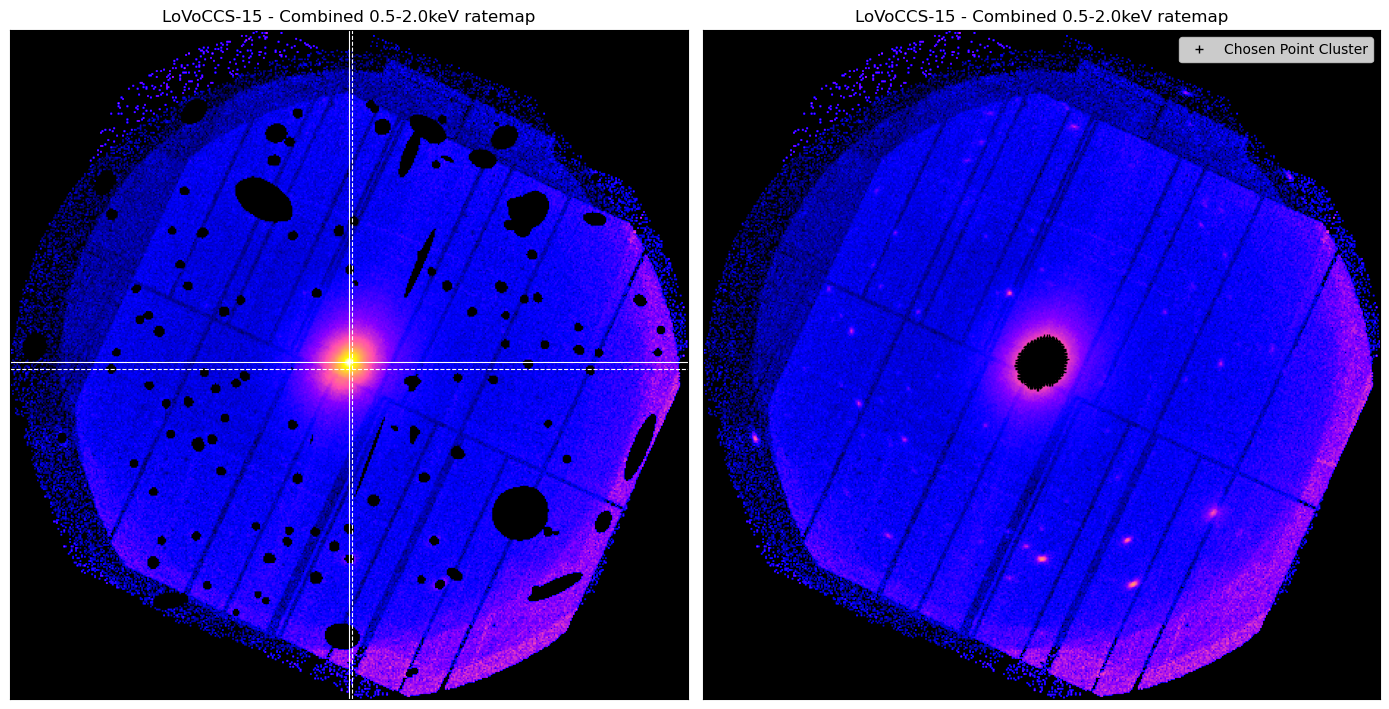

ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


ZeroDivisionError: float division

Exception ignored in: 'regions._geometry.elliptical_overlap.elliptical_overlap_single_subpixel'
Traceback (most recent call last):
  File "/mnt/home/turne540/software/anaconda3/envs/xga_env/lib/python3.8/site-packages/regions/shapes/ellipse.py", line 175, in to_mask
    fraction = elliptical_overlap_grid(
ZeroDivisionError: float division


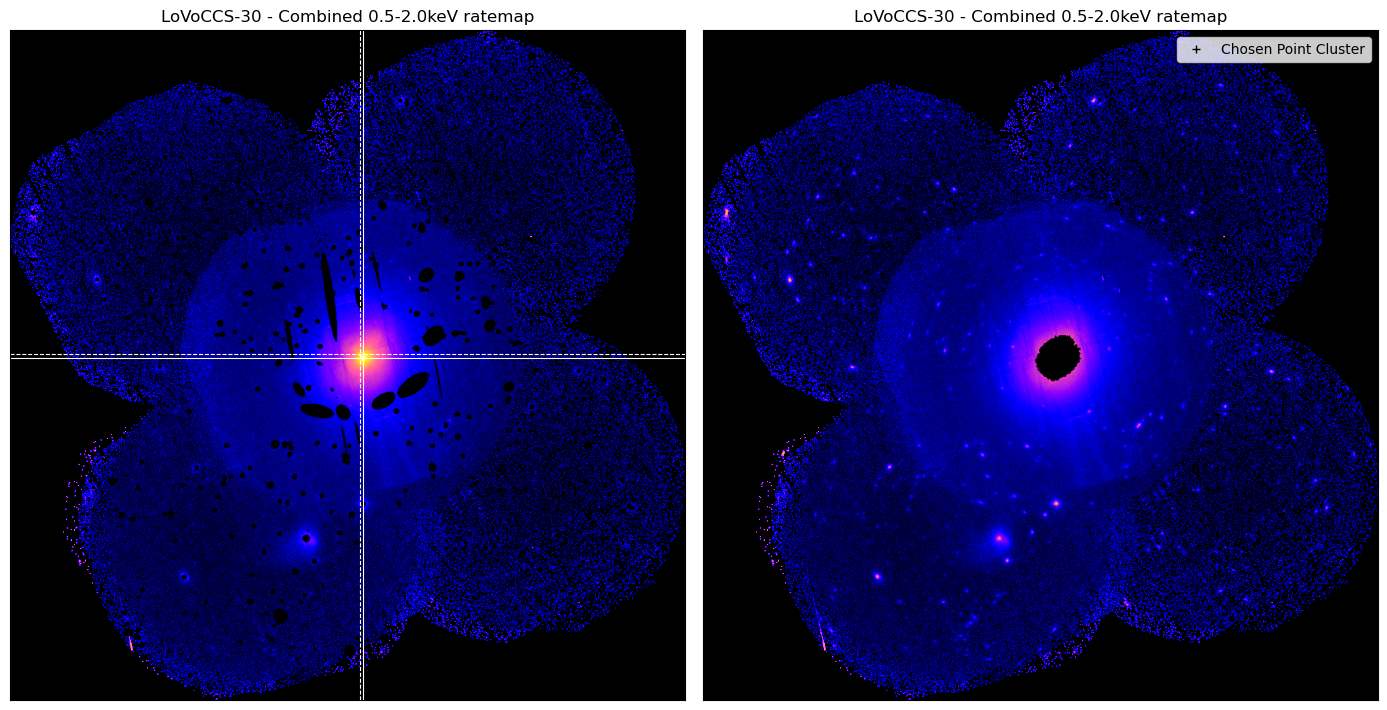

In [8]:
for src in srcs:
    # Fetch the combined ratemap that was used for peak identification
    cur_rt = src.get_combined_ratemaps()
    cur_chos_pnt_clst = src.point_clusters[0]
    cur_oth_pnt_clst = src.point_clusters[1]
    cur_int_mask = src.get_interloper_mask()

    fig, ax_arr = plt.subplots(ncols=2, figsize=(14, 7))
    for ax_ind, ax in enumerate(ax_arr):
        plt.tick_params(left=False, right=False, top=False, bottom=False)

    cur_rt.get_view(ax_arr[0], Quantity([src.peak, src.ra_dec]), cur_int_mask, zoom_in=True)

    cur_rt.get_view(ax_arr[1], chosen_points=cur_chos_pnt_clst, other_points=cur_oth_pnt_clst, zoom_in=True)
    plt.tight_layout()
    
    file_name = "{n}_xmm_peak_search_vis.pdf".format(n=src.name)
    plt.savefig("../../outputs/cluster_visualisations/peak_coord_meas/"+file_name)
    plt.show()

## Saving the peak coordinates

We make sure to save the peak coordinates to a truncated sample file (just containing cluster name and the measured positions):

In [11]:
out_df_data = np.concatenate([srcs.names[..., None], srcs.peaks.value], axis=1)
out_df = pd.DataFrame(out_df_data, columns=['LoVoCCS_name', 'peak_ra', 'peak_dec'])
out_df.to_csv("../../outputs/coordinates/xmm_peak_coords.csv", index=False)
out_df

,LoVoCCS_name,peak_ra,peak_dec
0,LoVoCCS-15,351.33239477984495,-12.123932628849191
1,LoVoCCS-30,139.5253050046849,-12.095976058217337
